<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-Loading" data-toc-modified-id="Imports-and-Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data Loading</a></span></li><li><span><a href="#Closer-Look-on-chosen-company" data-toc-modified-id="Closer-Look-on-chosen-company-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Closer Look on chosen company</a></span></li><li><span><a href="#Model-fit-for-Chosen-company.-Case-without-FS" data-toc-modified-id="Model-fit-for-Chosen-company.-Case-without-FS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model fit for Chosen company. Case without FS</a></span></li><li><span><a href="#FS-Loading,-cleaning-and-input-preparation" data-toc-modified-id="FS-Loading,-cleaning-and-input-preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>FS Loading, cleaning and input preparation</a></span></li><li><span><a href="#Model-fit-for-Chosen-compant.-Case-with-FS" data-toc-modified-id="Model-fit-for-Chosen-compant.-Case-with-FS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model fit for Chosen compant. Case with FS</a></span></li></ul></div>

**Description**  
This notebook will conduct a study on the impact of financial statements on model learning and the accuracy of forecasts

**Limitiations**  
Unlike the previous parts of the Project, the task described above will be implemented with a number of significant constraints, detailed below.  


- Unfortunately, not all financial reports are available for the previously selected cluster centres, only one company is available - NBTB (Bancorp Inc), a company from the financial sector listed on the Nasdaq Exchange and representing the centre of a sufficiently large cluster consisting of 92 companies.


- So as an experiment, a full cycle and training will be conducted for NBTB only, with the following steps:
  - quarterly financial statements (FS) loading
  - FS cleaning
  - data preparation for NN
  - finding optimal hyperparams for NN
  - fit stage
  - metric comparison


- Comparison will be applied on the model which will be fitted only on normalized prices and date features (as in previous part of Project)


- It is important to note that in the previous step, I used a single architecture option for all composites and cluster centers in order to optimize code running time. However, in this case, since the configuration of the parameters for the financial reporting model will be done point by point for the financial reporting model variant, for the sake of correct comparison, the version of the model without financial reporting will also be re-adjusted to the individual characteristics of the time series.


- and, as before, I will use a fixed window size of 90 days.

**Notices**  
- Some parts of code can take a lot of time and can be ignored
- In order to save previous results of running (e.g. learning curves) - do not run these cells
- These cells are: 3.3, 3.4, 3.5, 5.1, 5.2, 5.3
- For successful launch of the remaining cells it is necessary to run them sequentially (despite the presence of checkpoints) 

**Important Disclaimer**  

***This notebook considers the analysis and construction of the predictive model of only one company NBTB, in connection with the need to emphasize the following:***


- The choice of this company is due solely to the results of the cluster analysis in the previous steps, where there is also an element of randomness (when selecting a cluster center from several centers) and the availability of financial statements used in the project API-service. 
- In other words, when restarting the code from `S4_EDA_Clustering` - another company can be defined as the center of the cluster
- All input data was obtained exclusively from public sources (description in the first part of the Project).
- All conclusions relate only to the predictive capacities of the models under consideration in this Project and are implemented solely within the framework of an educational project with no commercial goals.
- In addition, the work does not provide any meaningful analysis of the financial statements
- Model predictions cover only the historical period and are not made for future periods
- **Thus, the results of the analysis can only be considered in the context of the objectives of this project and cannot be used, in whole or in part, for making any investment decisions.**

#### Imports and Data Loading

In [1]:
# 1.1 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, pickle, os
import seaborn as sns
import warnings
import time
from datetime import date as dt
import itertools
from pprint import pprint
import requests
import json

from sklearn.metrics import r2_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

In [2]:
# 1.2. Configs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

%matplotlib inline
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [3]:
# 1.3. project_lib functions

from project_lib import get_jsonparsed_data
from project_lib import show_groups_dynamics_single_df
from project_lib import add_period_cols, split_to_train_test, scale_data, create_tensor
from project_lib import build_rnn_multiple_lstm, fit_run_plot
from project_lib import forecast_1step_rnn, forecast_Nsteps_rnn, create_binnary_vector
from project_lib import plot_corr_map

In [4]:
# 1.4. Data Loading

# normalized prices for cluster centers before scaling in one dataframe
with open('datasets_4_modelling/cluster_composite_norm.pkl', 'rb') as f:
    cluster_composite_norm = pickle.load(f)

# normalized prices for sector composites before scaling in one dataframe
with open('datasets_4_modelling/sector_composite_norm.pkl', 'rb') as f:
    sector_composite_norm = pickle.load(f)
    
# scaled and splitted prices and scalers for cluster centers (ready for RNN)
with open('datasets_4_modelling/scaled_splitted_clusters.pkl', 'rb') as f:
    scaled_splitted_clusters = pickle.load(f)
    
# comps list and quotes contains in cluster centers
with open('datasets_4_modelling/cluster_test_comps.pkl', 'rb') as f:
    clusters_comps = pickle.load(f)

# initial company profiles
profiles = pd.read_csv('datasets/df_profiles_cleaned.csv')

# PCT prices for cluster centers
cluster_centers_all = pd.read_csv('datasets_4_modelling/cluster_composites.csv', encoding='utf-8')

# Previous RNN metrics
with open('datasets_4_modelling/rnn_basic_results.pkl', 'rb') as f:
    rnn1_metrics = pickle.load(f)

#### Closer Look on chosen company

Let's look on some data and time series of chosen company

In [5]:
# 2.1. company profile
chosen_ticker = 'NBTB'

comp_profile = profiles.loc[profiles.symbol==chosen_ticker].drop(columns=['Unnamed: 0', 'ceo'], axis=1)
comp_profile = comp_profile.set_index('symbol').to_dict()
for col in comp_profile.keys():
    print(f'{col}: {comp_profile[col][chosen_ticker]}')

companyName: NBT Bancorp Inc.
sector: Financial Services
industry: Banks
exchange: Nasdaq Global Select
description: NBT Bancorp Inc provides financial services. The company, through community banks, mainly provides consumer loans, home equity loans, mortgages, business banking loans, and commercial loans.
mktCap: 1303499900.0


correlation coefficient between NBTB and Finance composite: 0.73


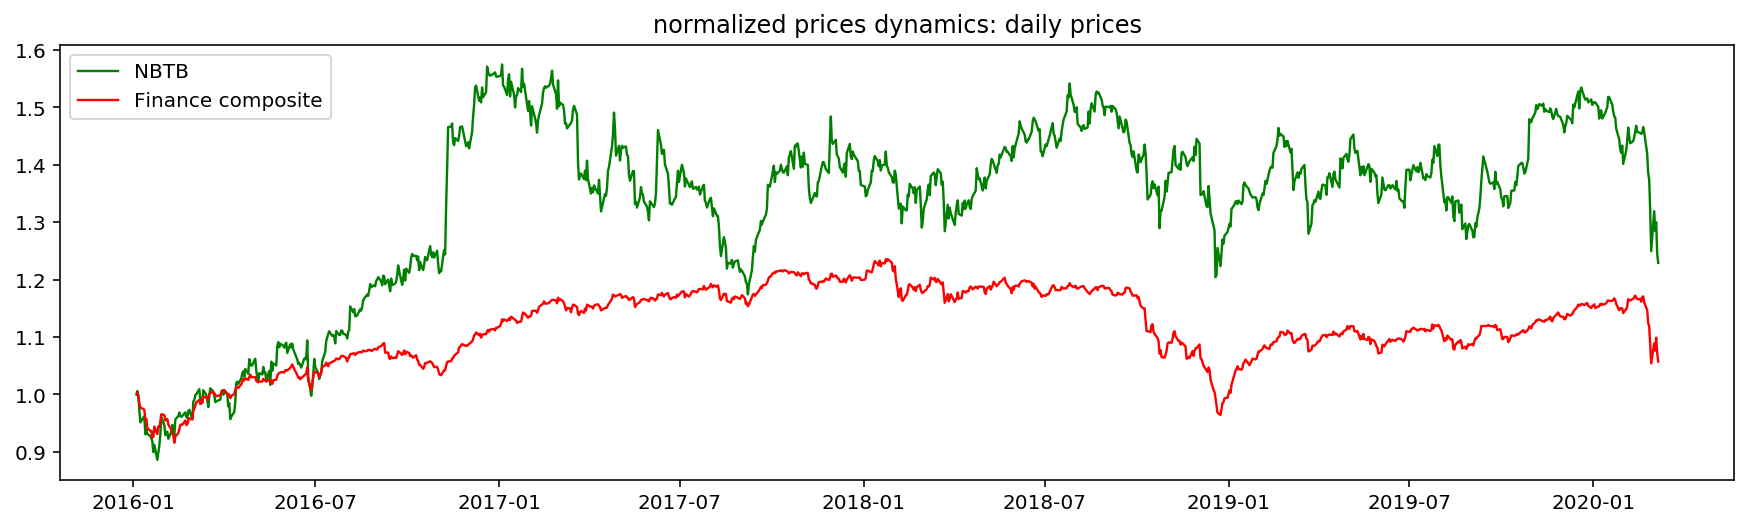

In [6]:
# 2.2. Company quotes dynamics (normalized prices)
chosen_ts = cluster_composite_norm[chosen_ticker]
sector_ts = sector_composite_norm['Financial']
corr_coef = np.corrcoef(chosen_ts[1:], sector_ts)[0][1]
print(f'correlation coefficient between NBTB and Finance composite: {corr_coef:.2f}')

fig = plt.figure(figsize=(15,4))
sns.lineplot(data=chosen_ts, c='green', linewidth=1.2, label=chosen_ticker)
sns.lineplot(data=sector_ts, c='red', linewidth=1.2, label='Finance composite')
plt.title('normalized prices dynamics: daily prices')
plt.show()

Finance Composite looks smoother because of its nature, but general trends are similar with the company, which could be indicated by good positive correlation (0.73)

In [7]:
# 2.3. Cluster of chosen ticker. Companies profiles
clusters_companies = clusters_comps[chosen_ticker]
clusters_companies_symbols = clusters_companies.columns.to_list()
profiles_cluster = profiles.drop(columns=['Unnamed: 0', 'description', 'ceo'], axis=1)
profiles_cluster = profiles_cluster.loc[profiles_cluster.symbol.isin(clusters_companies_symbols)]
profiles_cluster = profiles_cluster.set_index('symbol')

print(f'allocation for sector: {profiles_cluster.sector.value_counts()}')
print(50*'-')
print(f'allocation for industry: {profiles_cluster.industry.value_counts()}')
print(50*'-')
print(f'allocation for exchange: {profiles_cluster.exchange.value_counts()}')

allocation for sector: Financial Services    88
diversified            4
Name: sector, dtype: int64
--------------------------------------------------
allocation for industry: Banks               87
diversified          4
Banksâ€”Regional     1
Name: industry, dtype: int64
--------------------------------------------------
allocation for exchange: Nasdaq Global Select       71
New York Stock Exchange    12
NYSE Arca                   3
NYSE American               2
NASDAQ Global Market        2
NASDAQ Capital Market       1
NasdaqGS                    1
Name: exchange, dtype: int64


Almost all cluster companies belongs to Financial Sector and Bank industry. Most of those are listed in NASDAQ.

 monthly price margin dynamics for NBTB
----------------------------------------------------------------------------------------------------


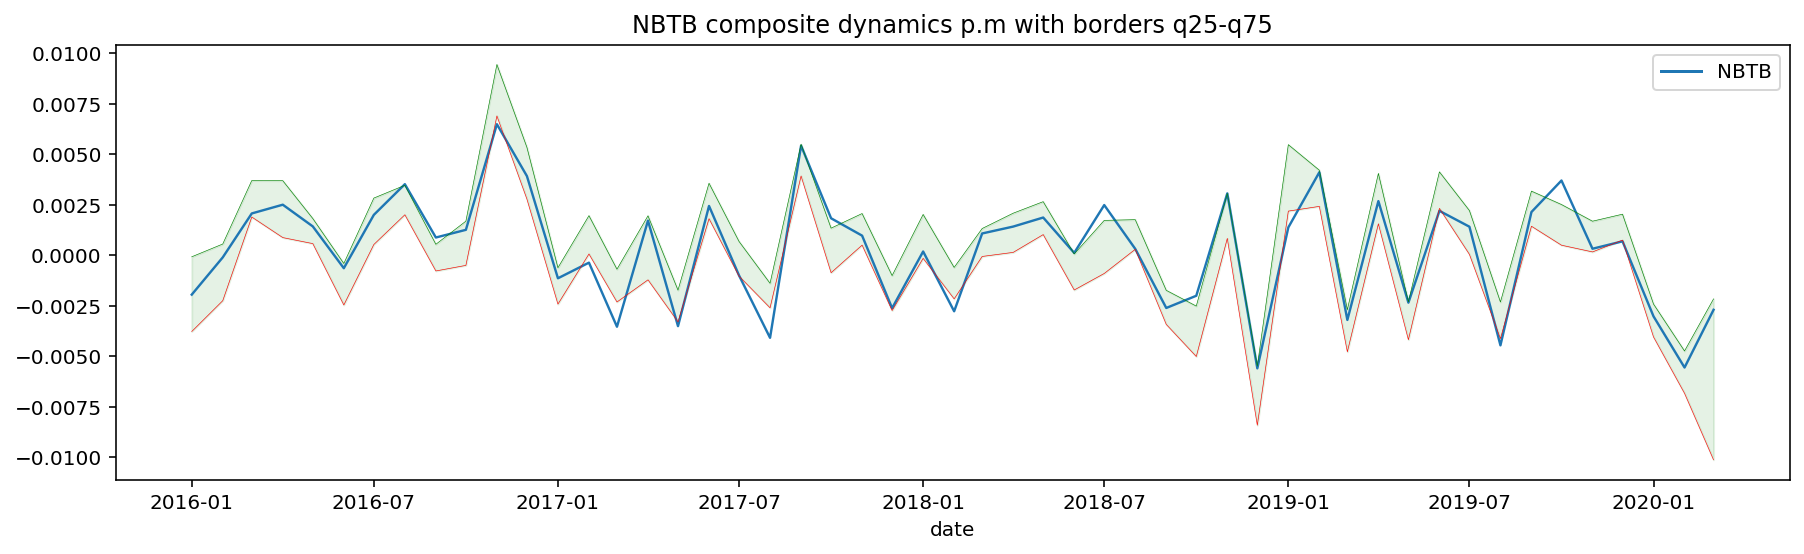

In [8]:
# 2.4. Net Price Margin dynamics in cluster
cluster_centers_all = cluster_centers_all.set_index('date')
print(f' monthly price margin dynamics for {chosen_ticker}')
print(100*'-')
show_groups_dynamics_single_df(clusters_comps, chosen_ticker, cluster_centers_all,
                                   period='MS',  borders='q25-q75')


Chosen company is quite representative to the cluster. 

Как видно из динамики доходности, в целом выбранная компания достаточно репрезентативна для своего кластера.  
In this case, unlike composite indexes, which in essence averages the indicators of the cluster, this company is not required to have a value within the given quantile, but its indicators are relatively highly correlated with the indicators of the cluster company.  
More specifically, the selected company is often closer to the upper boundary.

#### Model fit for Chosen company. Case without FS

On the previous steps, the universal architecture for RNN models {1-LSTM(128) - Dropout(0.1) - FC(1)} was selected.   However, this architecture was chosen on the basis of randomly selected companies, in particular on the composite Financial and the company IXG.  


In this step I will repeat the previous steps, but already for the company selected here, and perhaps I can improve the metrics of the model.

In [9]:
# 3.1. Looking to optimal Architecture. Previous steps
universal_params = dict(
                  lstm_units=128, lstm_activation='relu', use_dropout=True, dropout_rate=0.10, 
                  n_internal_lstm=0, add_internal_dense=False, optimizer='adam', 
                  loss_function='mse', show_model_layers=False
                    ) # previous architecture
old_metrics = rnn1_metrics.loc[rnn1_metrics.cluster_name==chosen_ticker].to_dict()
for col in old_metrics.keys():
    print(f'{col}: {old_metrics[col][22]}')

cluster_type: corr_cluster
cluster_name: NBTB
r2_1d: 0.8115985068295386
r2_125d: -0.9729963719712389
acc_1d: 0.5238095238095238
f1_1d: 0.46428571428571425
acc_125d: 0.544
f1_125d: 0.4770642201834862


Let's fix in memory - r2_1d = 0.81

In [10]:
# 3.2. Loading and preparing input data

train_scaled, test_scaled, scaler, target_scaler = scaled_splitted_clusters[chosen_ticker]

train_tensor, train_target = create_tensor(train_scaled, train_scaled[chosen_ticker],
                                                         window_size=90, show_shape=True)

test_tensor, test_target = create_tensor(test_scaled, test_scaled[chosen_ticker],
                                                         window_size=90, show_shape=True)


shape of input tensor: (777, 90, 3)
shape of input tensor: (126, 90, 3)


Unlike the previous steps, I will not enable the `use_early_stopping` option for higher accuracy and will also increase the number of epochs to 200.

I also modified hyperparam space:
- number of nodes (lstm-memory): {90, 128, 144}
- dropout rate: {0.10, 0.15, 0.20}


Here I will not test the model on additional hidden FC-layer

Other params are the same, as in `S6_RNN_Basic.ipynb`:
- validation_split: 0.15
- batch_size: 16
- lstm_layers: 1

calculations for 128 nodes - 0.1 dropout_rate - 1 LSTM layers started..
total time for learning: 414.2570753097534 sec


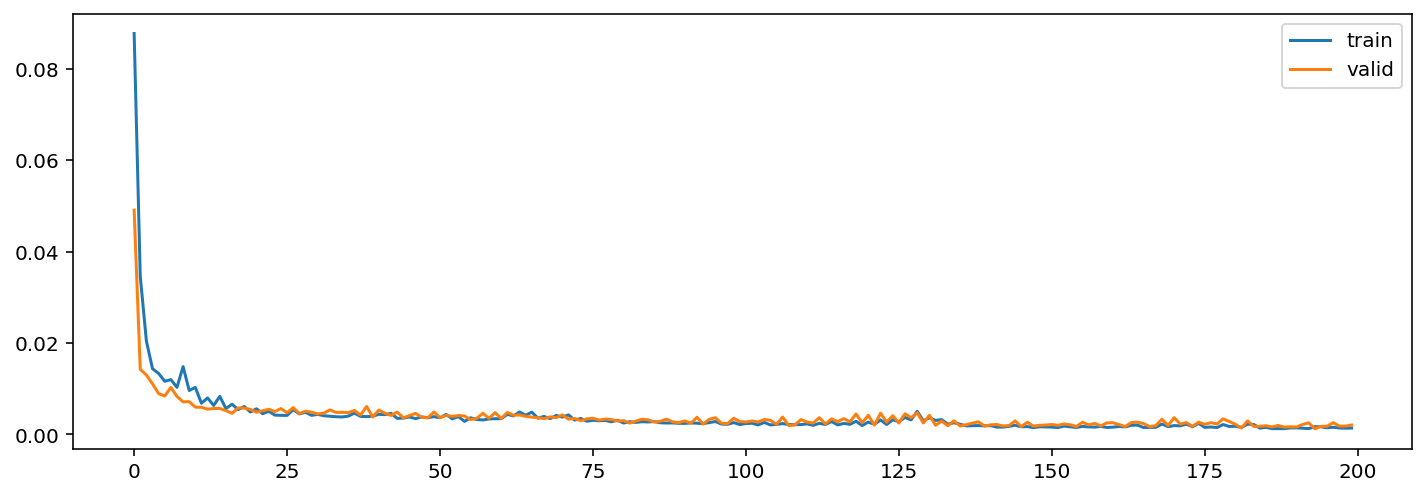

best epoch for valid set 193
best loss for valid set 0.001223372667381126
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.15 dropout_rate - 1 LSTM layers started..
total time for learning: 394.8345596790314 sec


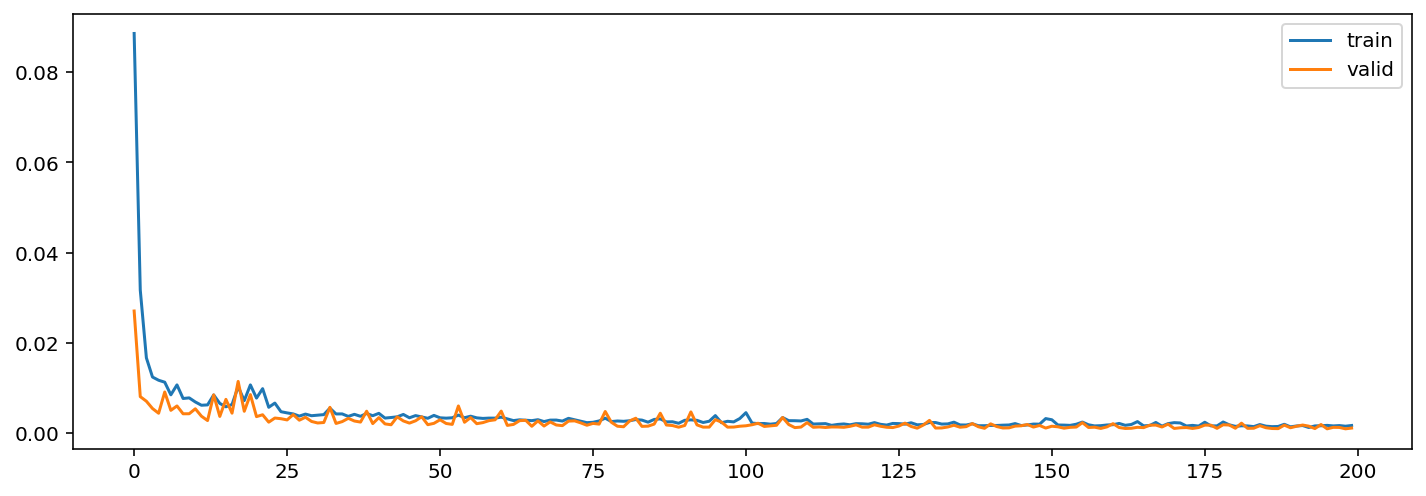

best epoch for valid set 195
best loss for valid set 0.0009346692785560989
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.2 dropout_rate - 1 LSTM layers started..
total time for learning: 393.1484341621399 sec


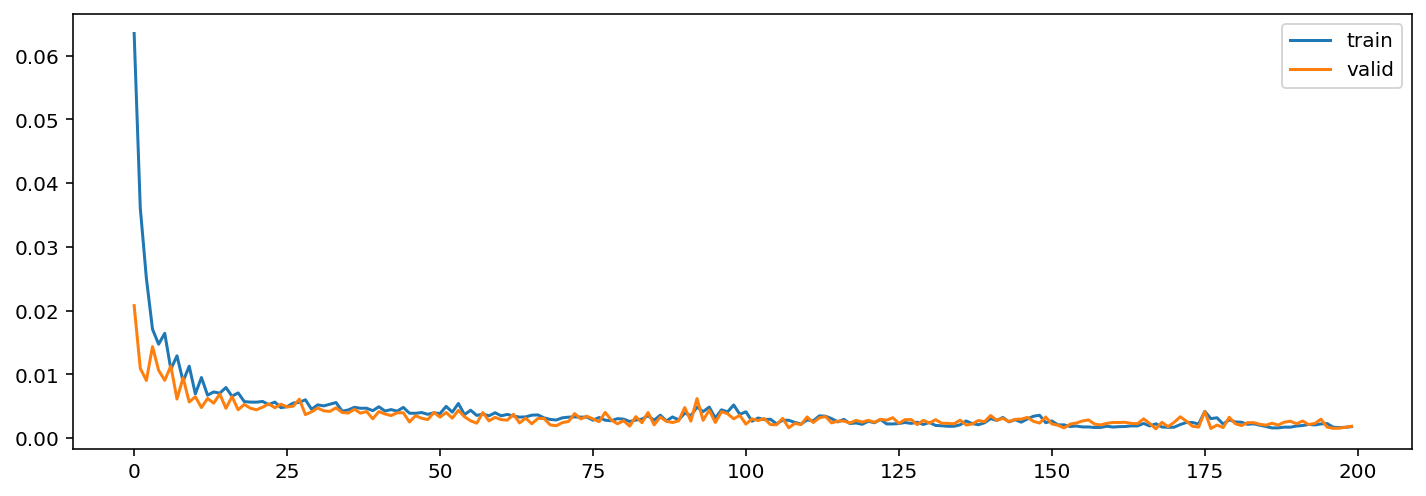

best epoch for valid set 167
best loss for valid set 0.0014718847362221116
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.1 dropout_rate - 1 LSTM layers started..
total time for learning: 399.64937114715576 sec


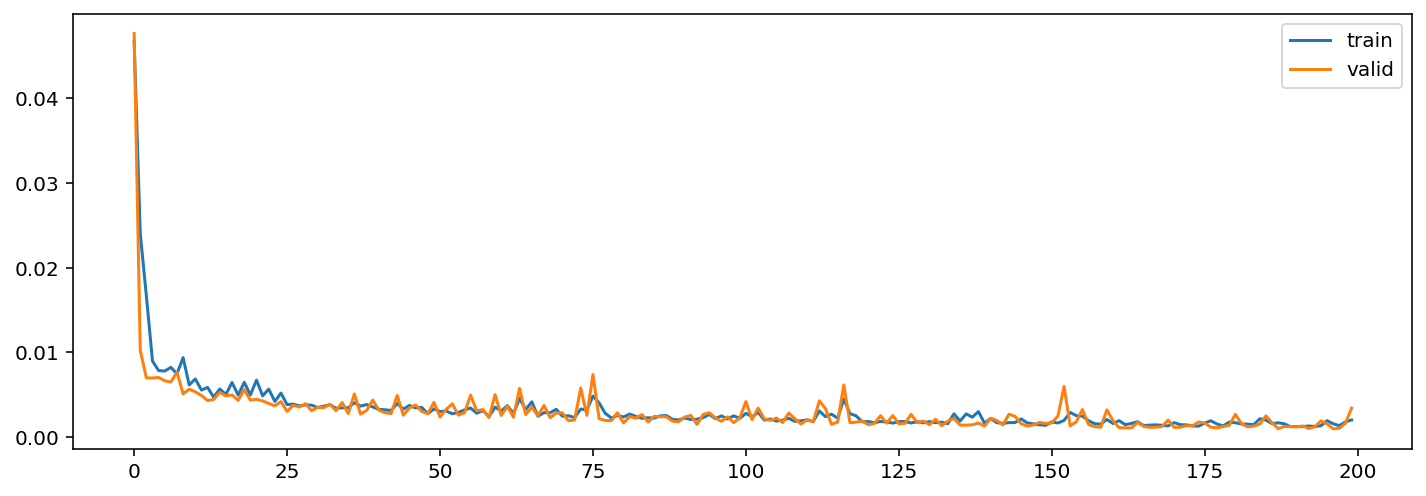

best epoch for valid set 196
best loss for valid set 0.000963869184985932
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.15 dropout_rate - 1 LSTM layers started..
total time for learning: 400.53653717041016 sec


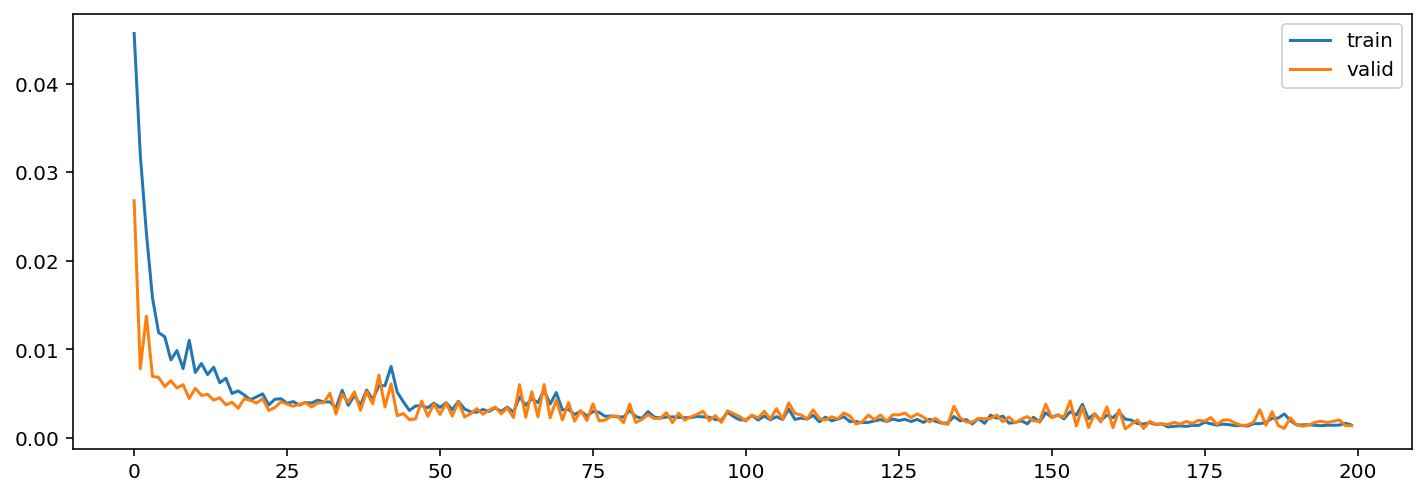

best epoch for valid set 162
best loss for valid set 0.0010383573801527356
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.2 dropout_rate - 1 LSTM layers started..
total time for learning: 397.50480937957764 sec


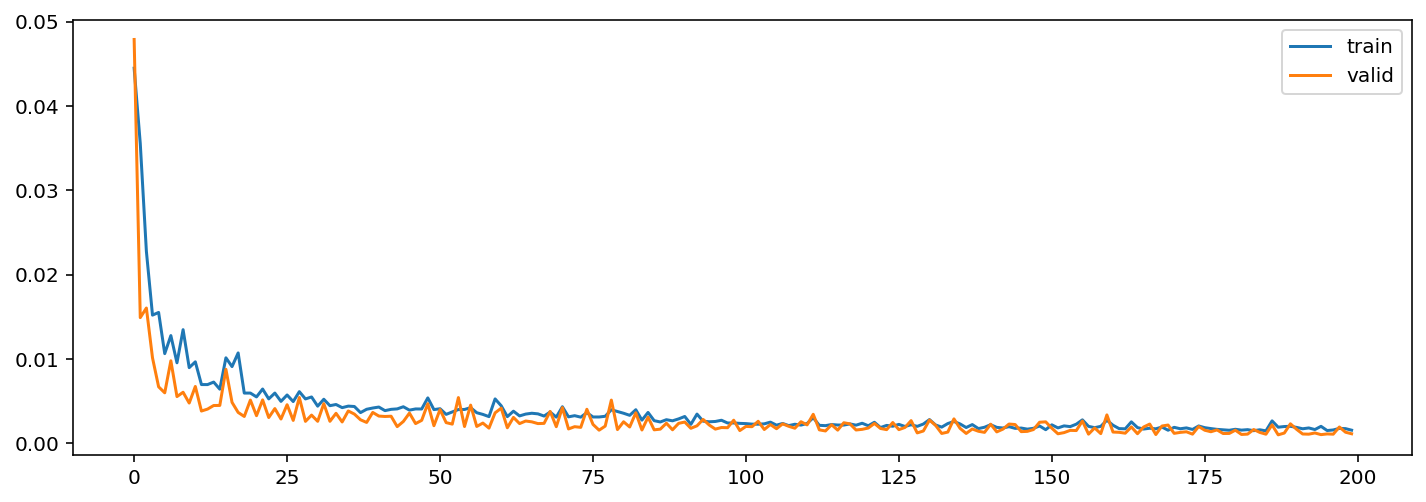

best epoch for valid set 187
best loss for valid set 0.0009955868339384946
------------------------------------------------------------------------------------------
calculations for 160 nodes - 0.1 dropout_rate - 1 LSTM layers started..
total time for learning: 394.2128026485443 sec


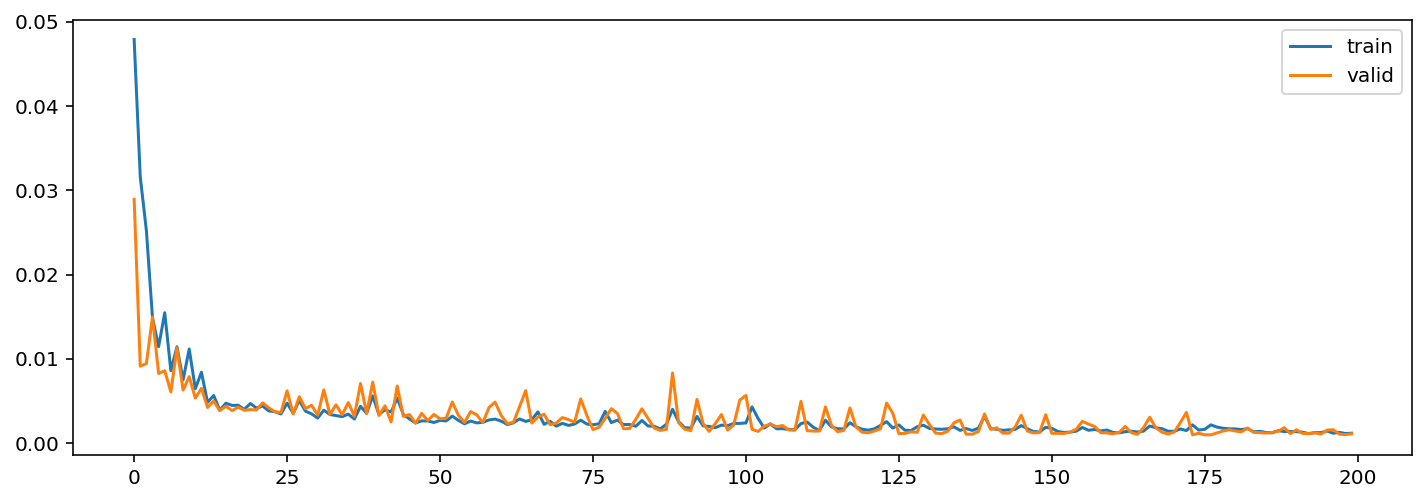

best epoch for valid set 176
best loss for valid set 0.0009903168225159438
------------------------------------------------------------------------------------------
calculations for 160 nodes - 0.15 dropout_rate - 1 LSTM layers started..
total time for learning: 404.0379524230957 sec


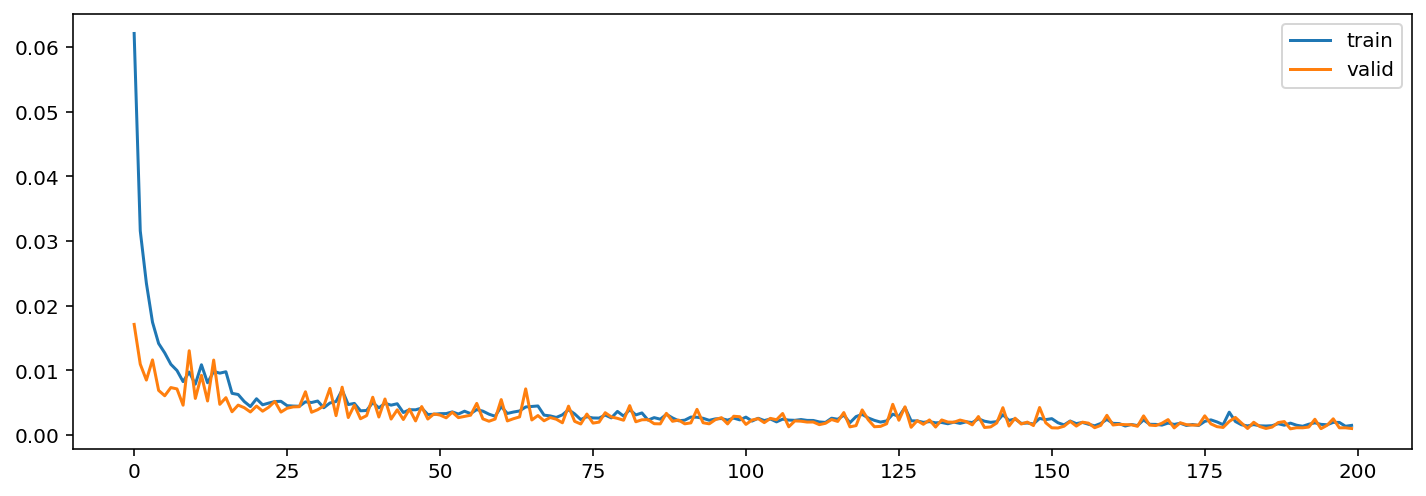

best epoch for valid set 189
best loss for valid set 0.0009781334484015934
------------------------------------------------------------------------------------------
calculations for 160 nodes - 0.2 dropout_rate - 1 LSTM layers started..
total time for learning: 416.22318601608276 sec


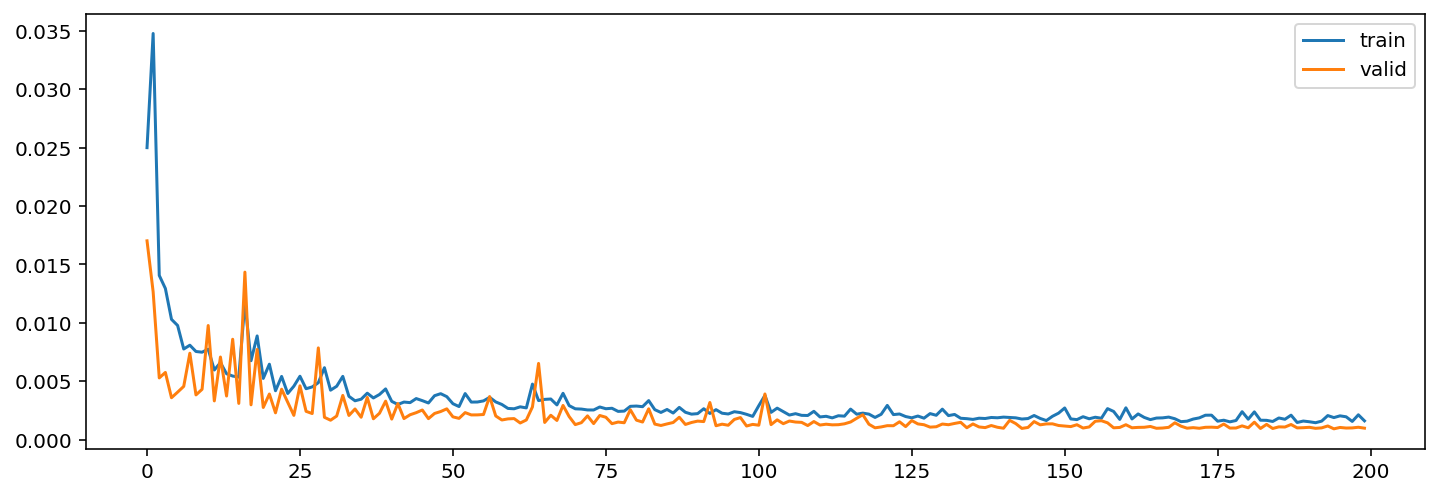

best epoch for valid set 194
best loss for valid set 0.0009247540102268641
------------------------------------------------------------------------------------------


In [11]:
# 3.3. Search on optimal hyperparameters
# attention: this cell can take up to 50 minutes with activated CUDA and GPU (1080Ti)
# it is recommended to ignore this cell
# do not run this cell or do not restart kernel with CLEAR output in order to keep results of previous run

lstm_n = [128, 144, 160]
dropout_rates = [0.1, 0.15, 0.20]
n_lstm = [0]

combs = list(itertools.product(lstm_n, dropout_rates, n_lstm))

titles = [str(i[0])+' nodes - '+str(i[1])+' dropout_rate - '+str(i[2]+1)+' LSTM layers' for i in combs]

param_grid = {t:dict(matrix_shape=train_tensor.shape[1:],
                    lstm_units=c[0],
                    dropout_rate=c[1],
                    n_internal_lstm=c[2]) 
              for t,c in zip(titles, combs)}

valid_losses, valid_epochs = [], []

for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, train_tensor, train_target, n_epochs=200, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), 
                           use_early_stopping=False)

    v_loss = np.array(history.history['val_loss'])
    
    valid_losses.append(v_loss.min())
    valid_epochs.append(v_loss.argmin())
    
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

In [12]:
# 3.4. Optimal params


opt_params_simple =  dict(
                          lstm_units=144, lstm_activation='relu', use_dropout=True, dropout_rate=0.20, 
                          n_internal_lstm=0, add_internal_dense=False, optimizer='adam', 
                          loss_function='mse', show_model_layers=False
                          )

Based on some visual look, I've chosen LSTM(144), Dropout(0.20) as optimum for the company.  
- results and shapes could be changed after re-running this cell

On next cell I will train model and save it to `models` folder. As it was in STEP-6, fitting process contains 2 steps: 
- (1) calculating history with defining optimal epoch number, 
- (2) refitting model with this epoches

In [15]:
# 3.5. Fitting the model. Saving model
# attention: this cell can take up to 15 minutes with activated CUDA and GPU (1080Ti)
# it is recommended to ignore this cell
# do not run this cell or do not restart kernel with CLEAR output in order to keep results of previous run

target = chosen_ticker
print(f'{target} started ...')
    
model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **opt_params_simple)
history = fit_run_plot(model, train_tensor, train_target, n_epochs=250, batch_size=16, 
                       validation_split=0.15, verbose_mode=0, show_chart=False, display_total_time=False, 
                       display_model_summary=False, return_history=True, use_early_stopping=False)
    
epoch_step = np.array(history.history['val_loss']).argmin()
v_loss = np.array(history.history["val_loss"]).min()
    
print(f'optimum epochs number {epoch_step} with val loss = {v_loss}')
final_model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **opt_params_simple)
final_model = fit_run_plot(final_model, train_tensor, train_target, n_epochs=epoch_step, batch_size=16, 
                           validation_split=0.01, verbose_mode=0, show_chart=False, display_total_time=False, 
                           display_model_summary=False, return_history=False, use_early_stopping=False)
    
path = f'models/{chosen_ticker}_simple.h5'
#final_model.save(path)

In [16]:
# 3.6. CHECKPOINT: loading saved model

path = f'models/{chosen_ticker}_simple.h5'
simple_model = load_model(path)

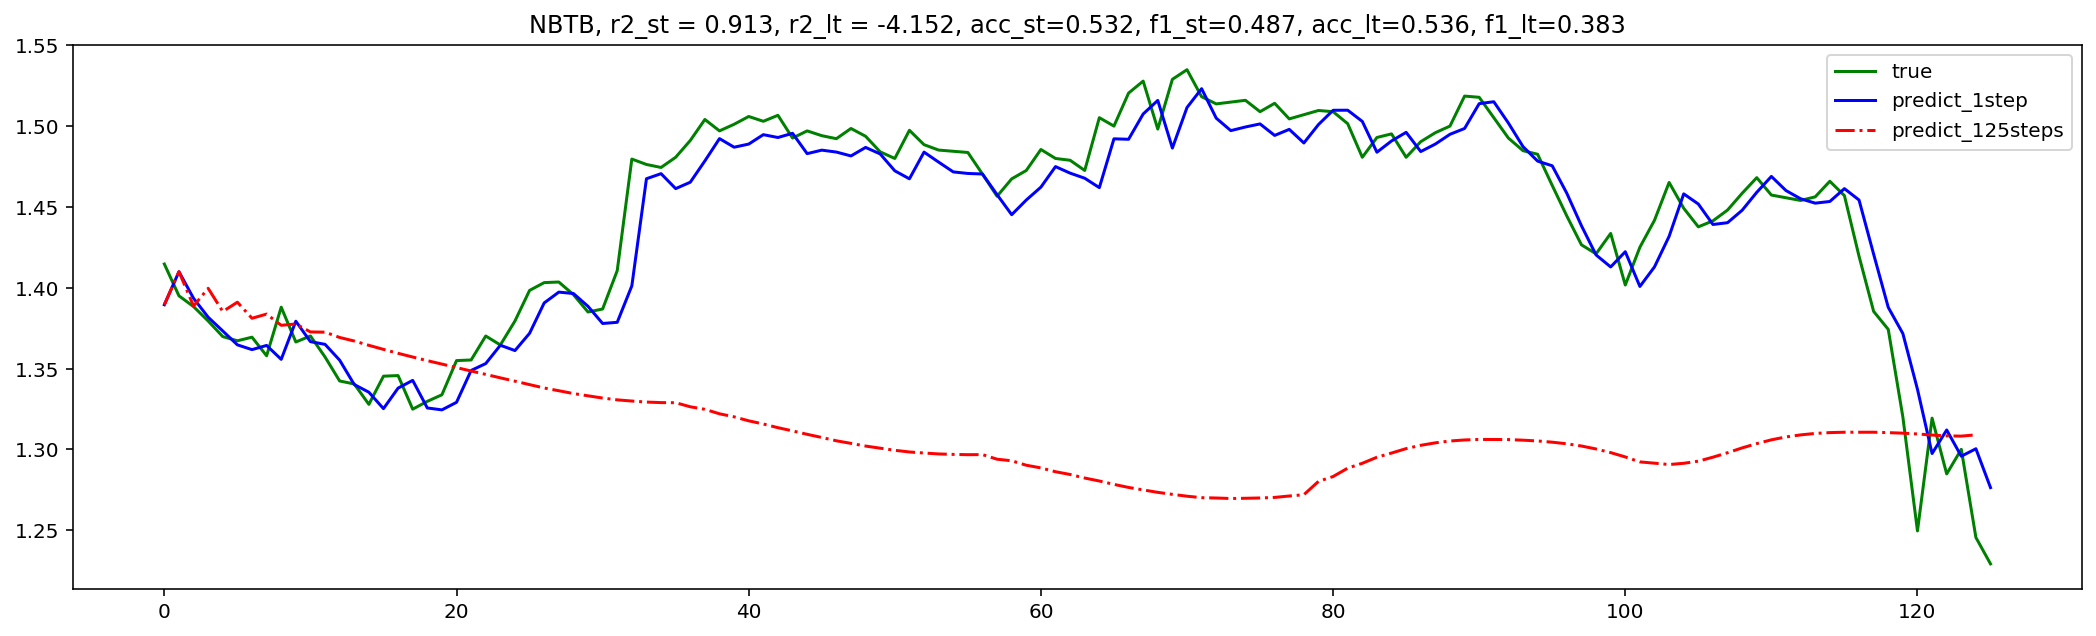

In [17]:
# 3.7. Forecast

target = chosen_ticker

pred, true = forecast_1step_rnn(fitted_model=simple_model, scaler_target=target_scaler, test_tensor=test_tensor,
                                       test_scaled=test_scaled, target_name=chosen_ticker, plot_chart=False)


pred_lt, true_lt = forecast_Nsteps_rnn(N_periods=125, fitted_model=simple_model, scaler_target=target_scaler, 
                                        test_scaled=test_scaled, target_name=chosen_ticker, plot_chart=False)

pred_bin = create_binnary_vector(pred) 
true_bin = create_binnary_vector(true)
true_lt_bin = create_binnary_vector(true_lt) # reduced length comparing to true_bin
pred_lt_bin = create_binnary_vector(pred_lt) 

r2 = round(r2_score(true, pred),3)
r2_lt = round(r2_score(true_lt, pred_lt),3)
acc = round(accuracy_score(true_bin, pred_bin),3)
acc_lt = round(accuracy_score(true_lt_bin, pred_lt_bin),3)
f1 = round(f1_score(true_bin, pred_bin),3)
f1_lt = round(f1_score(true_lt_bin, pred_lt_bin),3)

fig, ax = plt.subplots(1,1, figsize=(18,5))
ax.plot(true, c='g', label='true')
ax.plot(pred, c='b', label='predict_1step')
ax.plot(pred_lt, c='r', label='predict_125steps', linestyle='-.')
ax.legend(loc='best')

ax.set_title(f'{chosen_ticker}, r2_st = {r2}, r2_lt = {r2_lt}, acc_st={acc}, f1_st={f1}, acc_lt={acc_lt}, f1_lt={f1_lt}')
plt.show()

As it shown above, r2 score significantly increased from 0.81 to 0.91 for 1-step forecast.  
Long-term forecast based with appropriate quiality and based only on time series data still unavaliable for the model.

#### FS Loading, cleaning and input preparation

In [18]:
# 4.1. Loading FS through API-service

URL_IS_Q_JSON = "https://financialmodelingprep.com/api/v3/financials/income-statement/"
URL_BS_Q_JSON = "https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/"
URL_CF_Q_JSON = "https://financialmodelingprep.com/api/v3/financials/cash-flow-statement/"

url_is = URL_IS_Q_JSON+chosen_ticker+'?period=quarter&datatype=csv'
url_bs = URL_BS_Q_JSON+chosen_ticker+'?period=quarter&datatype=csv'
url_cf = URL_CF_Q_JSON+chosen_ticker+'?period=quarter&datatype=csv'

try:
    df1 = pd.read_csv(url_is)
    df2 = pd.read_csv(url_bs)
    df3 = pd.read_csv(url_cf)
    df_fsq = pd.concat(objs=[df1, df2, df3],  axis=0)
    display(df_fsq.head(3))
except Exception:
     pass
    
filename = chosen_ticker+'_fsq.csv'
path = f'data/fsq/{filename}'

with open(path, 'w', encoding='utf-8') as f:
    df_fsq.to_csv(f, encoding='utf-8', columns=df_fsq.columns)

,2009-06-30,2009-09-30,2009-12-31,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,2011-09-30,...,2017-12-31,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31,Date
0,5.869700e+07,6.043100e+07,6.282900e+07,6.189900e+07,101402000.0,50627000.0,50499000.0,49252000.0,50164000.0,50361000.0,...,73451000.0,73486000.0,75741000.0,77527000.0,78875000.0,77691000.0,78627000.0,78054000.0,77183000.0,Revenue
1,3.670000e-02,2.954154e-02,3.968162e-02,-1.480208e-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Revenue Growth
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cost of Revenue


In [19]:
# 4.2. Data Cleaning and cutting

# 4.2.1. Timeline cutting
df_fsq = df_fsq.set_index('Date')
df_fsq = df_fsq.T
timeline = pd.to_datetime(df_fsq.index)
df_fsq = df_fsq.set_index(timeline)
df_fsq = df_fsq.loc[df_fsq.index>='2015-12-31']

# 4.2.2. NANS identifying
print(f'total NANS is {df_fsq.isna().sum().sum()}')

total NANS is 0


For this case, I will try to identify those key items in the financial statements that are not strictly linked to the calculation formulas or that contain part of my information that is not available in other items.  
Simple example of idea above are relation between Revenue and Net Income: Net Income depends not only on Revenue, but also on other flows like OPEX and Tax etc, so Net Income will be included to feature list.

At the same time, it is necessary to minimize the number of features to simplify the model. Therefore, in the example above, instead of the original NetIncome formula components, I'll lay down NetIncome as 1 feature. Also, I will not include well-known and frequently used derivatives in the features, such as EPS or EBITDA margin, which are fully dependent on the FS items. 

In addition, the features will not include Balance Sheet items that in one way or another depend on opening balances and changes in Income Statement and Cash Flow Statements. Taking into account that eventually the data will be normalized to the values of the 1st period, the absolute values of Balance Sheet items do not play a significant role. 

The only derivative item to be recognized and calculated from balance sheet items is Debt-to-Equity Ratio
- D/E = Total Debt / (Other comprehensive income + Retained earnings (deficit) + Total shareholders equity)

So final feature list used as input data consist of:
- Revenue
- Operating Income
- Net Income
- Operational Cash Flow
- Investment Cash Flow
- Financial Cash Flow
- Dividents Per Share
- Leverage

{'Net Income-Revenue': 0.8896818568303462,
 'Revenue-Net Income': 0.8896818568303462}

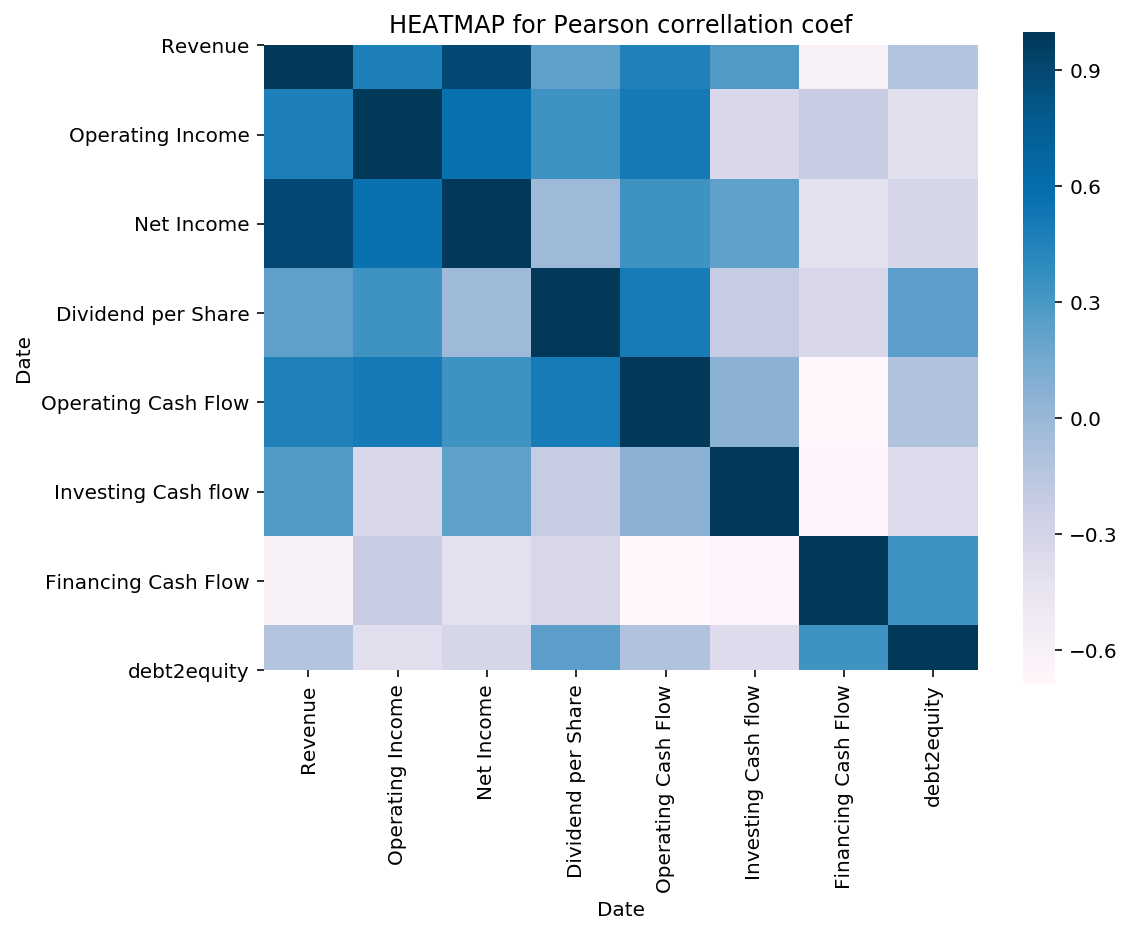

In [20]:
# 4.3. Selection of features and correlation analysis

fs_features = ['Revenue', 'Operating Income', 'Net Income', 'Dividend per Share', 'Total debt',
              'Retained earnings (deficit)', 'Other comprehensive income', 'Total shareholders equity', 
               'Operating Cash Flow', 'Investing Cash flow', 'Financing Cash Flow']

df_fsq_clean = df_fsq[fs_features]

df_fsq_clean['debt2equity'] = df_fsq_clean['Total debt'] / (df_fsq_clean['Other comprehensive income'] + 
                                                           df_fsq_clean['Retained earnings (deficit)'] +
                                                           df_fsq_clean['Total shareholders equity'])

df_fsq_clean = df_fsq_clean.drop(columns=['Total debt', 'Other comprehensive income', 
                                             'Retained earnings (deficit)', 'Total shareholders equity'], axis=1)   

# let's check correlation between remained features
corr_matrix = df_fsq_clean.corr()
plot_corr_map(corr_matrix)

correlated_features = dict()
corr_threshold = 0.7

for col in corr_matrix.columns:
    for row in corr_matrix[col].index:
        if corr_threshold < abs(corr_matrix.loc[row, col]) < 1.0:
            pair = f'{row}-{col}'
            correlated_features[pair] = corr_matrix.loc[row, col]

display(correlated_features)

As can be seen, Revenue and Net Income (0.89) are the most correlated of the remaining features.  

The next steps are to insert information from fsq to initial dataset. Given that quarterly reports appear only once a quarter, on all days between them will be inserted the last available quarterly reports for that period, which fully reflects the reality of investor knowledge in these periods.

In [21]:
# 4.4. Concatenating datasets

# 4.4.1. Combining datasets
full_dataset = pd.DataFrame(chosen_ts)
full_dataset = add_period_cols(full_dataset)
full_dataset = full_dataset.drop(columns=['day_of_week'], axis=1)
full_dataset = pd.concat(objs=[full_dataset, df_fsq_clean], axis=1)

# 4.4.2. Filling NANS by FFILL method and exluding first row
for col in full_dataset.columns:
    full_dataset[col] = full_dataset[col].fillna(method='ffill')

full_dataset = full_dataset[1:]

print(f'missing values: {full_dataset.isna().sum().sum()}')


missing values: 0


Next steps are standart for NN models and use project_lib functions:
- split data to train (0.8) and test (0.2)
- scaling data with MinMaxScaler
- transforming data to 3D-tensor with window_size = 90

In [22]:
# 4.5. Preparing dataset for model

df_train, df_test = split_to_train_test(full_dataset, test_portion=0.2)

df_train_scaled, df_test_scaled, df_scaler, df_scaler_target = scale_data(MinMaxScaler(), df_train, df_test, 
                                                                          target_name=chosen_ticker, 
                                                                          show_stats=True)

train_tensor, train_target = create_tensor(df_train_scaled, df_train_scaled[target], 
                                           window_size=90, show_shape=True)

test_tensor, test_target = create_tensor(df_test_scaled, df_test_scaled[target], 
                                           window_size=90, show_shape=True)

train dataset statistics


,NBTB,month,day_of_month,Revenue,Operating Income,Net Income,Dividend per Share,Operating Cash Flow,Investing Cash flow,Financing Cash Flow,debt2equity
count,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000
mean,0.624832,0.465688,0.491142,0.474481,0.676455,0.418041,0.204820,0.512204,0.334151,0.585519,0.596313
std,0.236639,0.316058,0.294055,0.318523,0.287190,0.339555,0.383756,0.271306,0.219335,0.236899,0.284242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.495961,0.181818,0.233333,0.205038,0.500433,0.161956,0.000849,0.395050,0.177511,0.475610,0.376146
50%,0.691438,0.454545,0.500000,0.397644,0.646900,0.217091,0.000891,0.438494,0.306034,0.591744,0.699344
75%,0.780829,0.727273,0.733333,0.796003,0.941158,0.861463,0.002013,0.742767,0.487871,0.739615,0.778105
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


test dataset statistics


,NBTB,month,day_of_month,Revenue,Operating Income,Net Income,Dividend per Share,Operating Cash Flow,Investing Cash flow,Financing Cash Flow,debt2equity
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000
mean,0.755769,0.552961,0.497859,0.941378,1.430000,1.058003,2.340688e-01,0.653912,0.465801,0.319137,0.008079
std,0.102895,0.320345,0.295044,0.034942,0.693062,0.113942,4.341697e-01,0.336686,0.365219,0.175380,0.198403
min,0.498115,0.000000,0.000000,0.889865,0.965357,0.930403,8.769433e-08,0.177665,-0.102372,0.000000,-0.263511
25%,0.683899,0.363636,0.233333,0.922932,1.038107,0.944125,8.769433e-08,0.177665,0.400133,0.240588,-0.263511
50%,0.735864,0.636364,0.500000,0.946560,1.131031,1.061463,1.006917e-03,0.810380,0.400133,0.413799,0.093609
75%,0.861335,0.818182,0.766667,0.983857,1.131031,1.211339,2.013475e-03,0.810380,0.662907,0.498758,0.093609
max,0.941842,1.000000,1.000000,0.983857,2.709919,1.211339,1.038531e+00,1.049017,1.000000,0.498758,0.262880


shape of input tensor: (783, 90, 11)
shape of input tensor: (128, 90, 11)


The sign space was increased from 3 to 11 features.  
In the next part of the notebook the optimal architecture selection, training and evaluation of the model metrics will be carried out

#### Model fit for Chosen compant. Case with FS

Internal studies have found relatively low efficiency of the ReLU function and high efficiency for TANH, so the hyperparameters are searched for by the following factors:
- lstm_n: {90, 128, 144}
- dropout rate: {0.10, 0.15, 0.20}
- activation function: {tanh}

calculations for 90 nodes - 0.1 dropout_rate - 1 layer tanh-fx started..
total time for learning: 60.48892545700073 sec


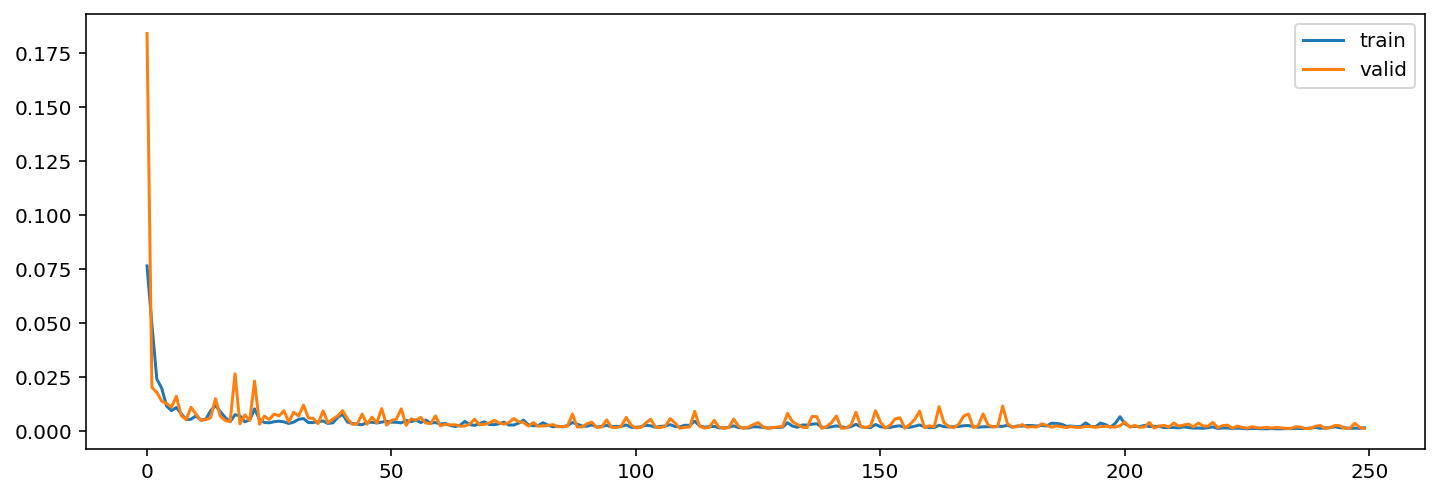

best epoch for valid set 241
best loss for valid set 0.0011217048997454093
------------------------------------------------------------------------------------------
calculations for 90 nodes - 0.15 dropout_rate - 1 layer tanh-fx started..
total time for learning: 60.42289853096008 sec


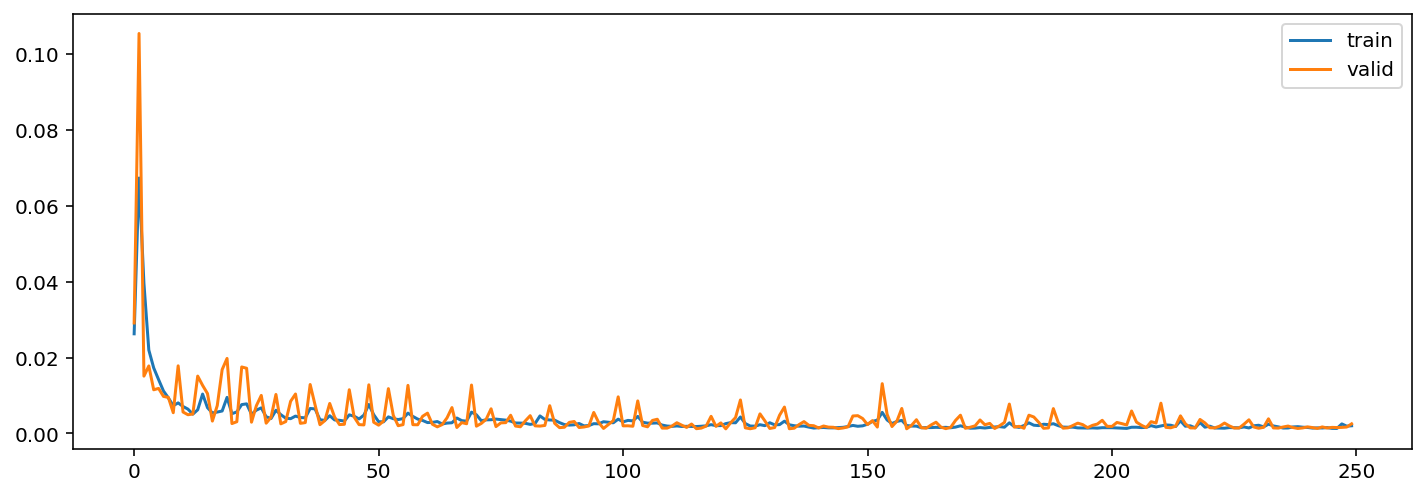

best epoch for valid set 121
best loss for valid set 0.0012109224098513565
------------------------------------------------------------------------------------------
calculations for 90 nodes - 0.2 dropout_rate - 1 layer tanh-fx started..
total time for learning: 61.11949014663696 sec


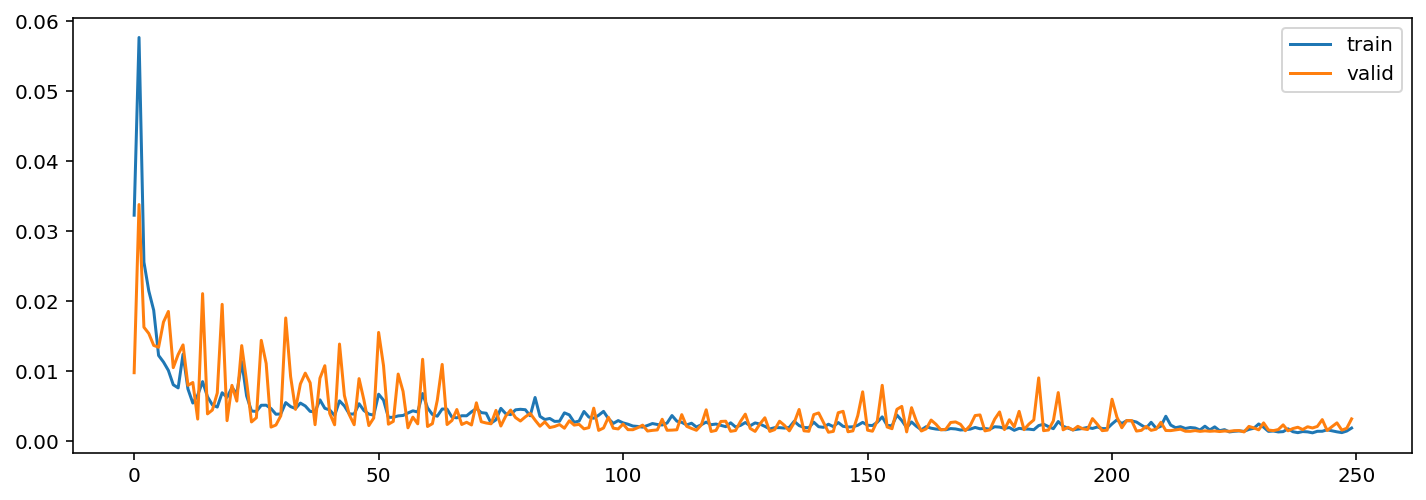

best epoch for valid set 142
best loss for valid set 0.0012181331364090665
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.1 dropout_rate - 1 layer tanh-fx started..
total time for learning: 65.13923335075378 sec


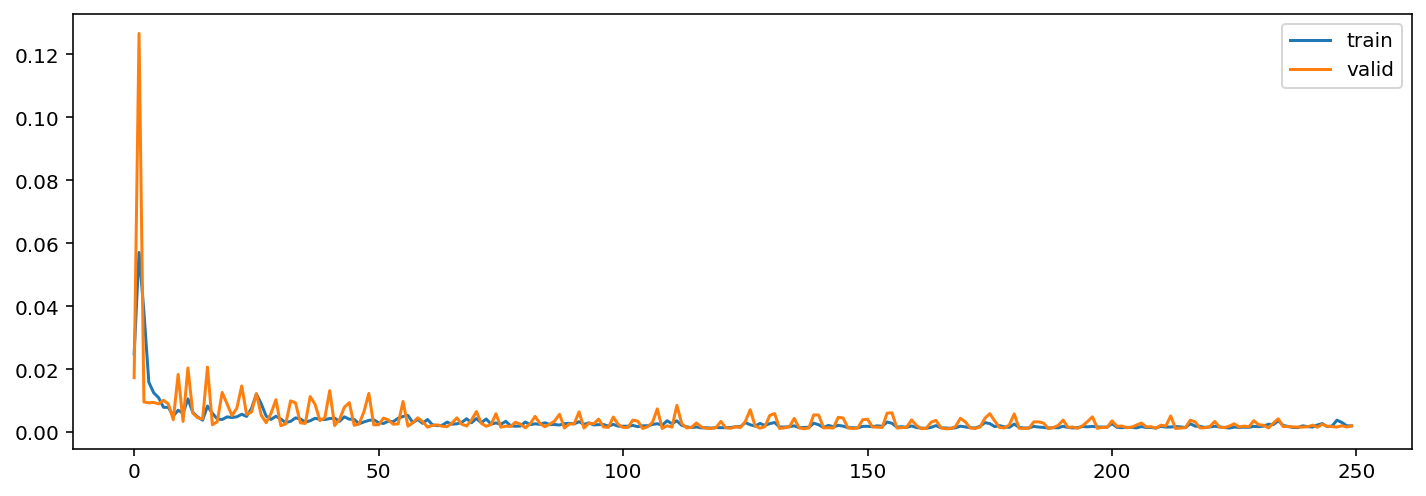

best epoch for valid set 166
best loss for valid set 0.0011061246317448253
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.15 dropout_rate - 1 layer tanh-fx started..
total time for learning: 62.81570386886597 sec


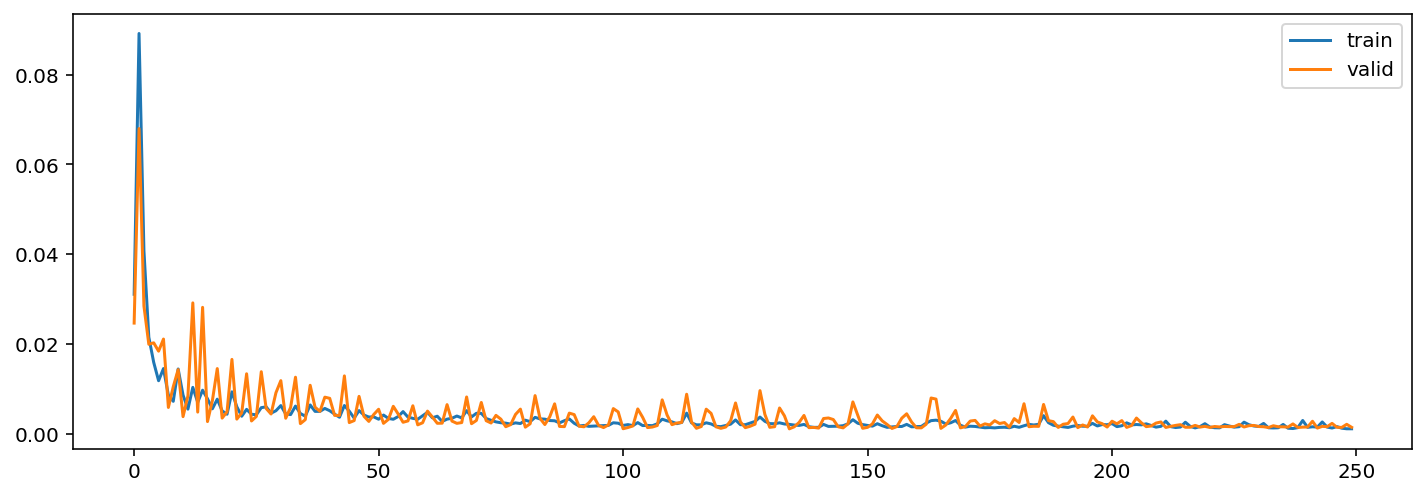

best epoch for valid set 134
best loss for valid set 0.0011620187768870492
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.2 dropout_rate - 1 layer tanh-fx started..
total time for learning: 63.37522768974304 sec


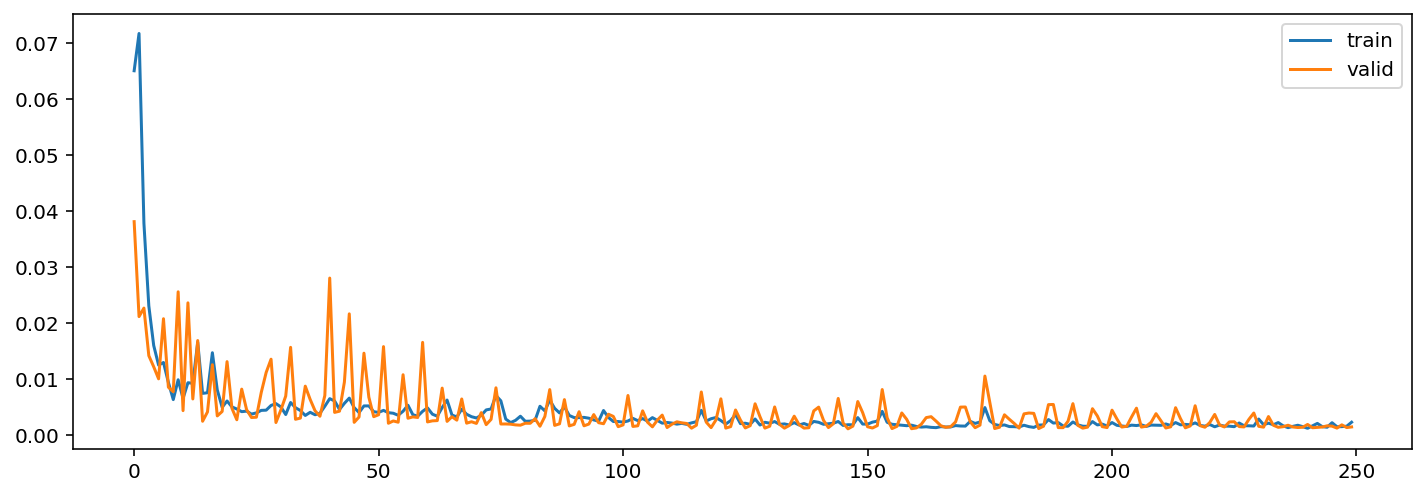

best epoch for valid set 146
best loss for valid set 0.0011574597249865153
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.1 dropout_rate - 1 layer tanh-fx started..
total time for learning: 61.585580587387085 sec


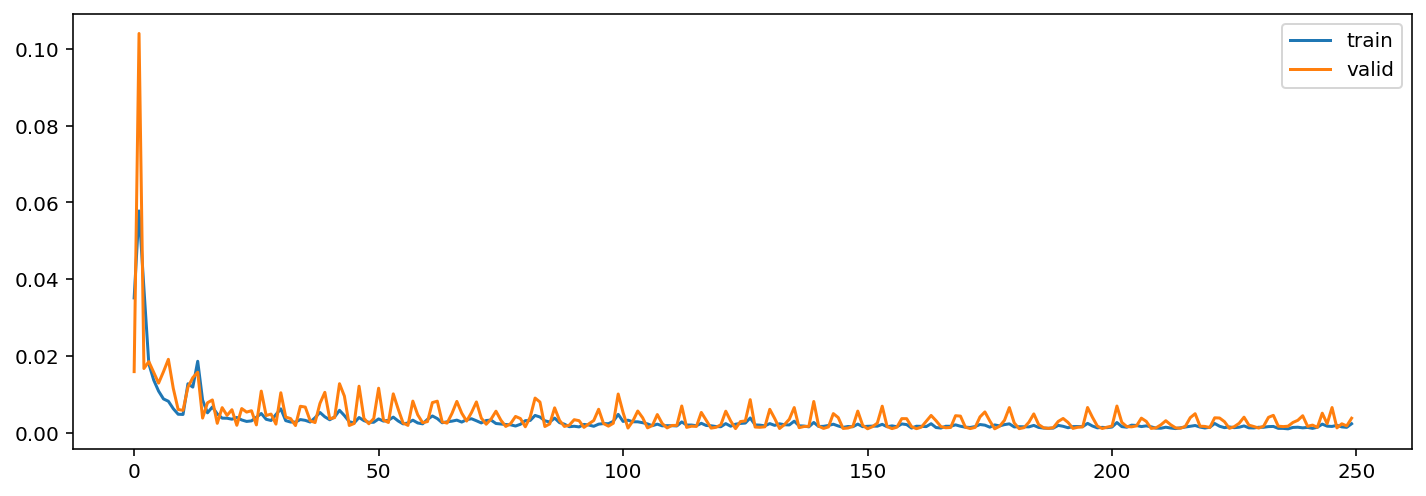

best epoch for valid set 176
best loss for valid set 0.0010886681039217797
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.15 dropout_rate - 1 layer tanh-fx started..
total time for learning: 61.583991050720215 sec


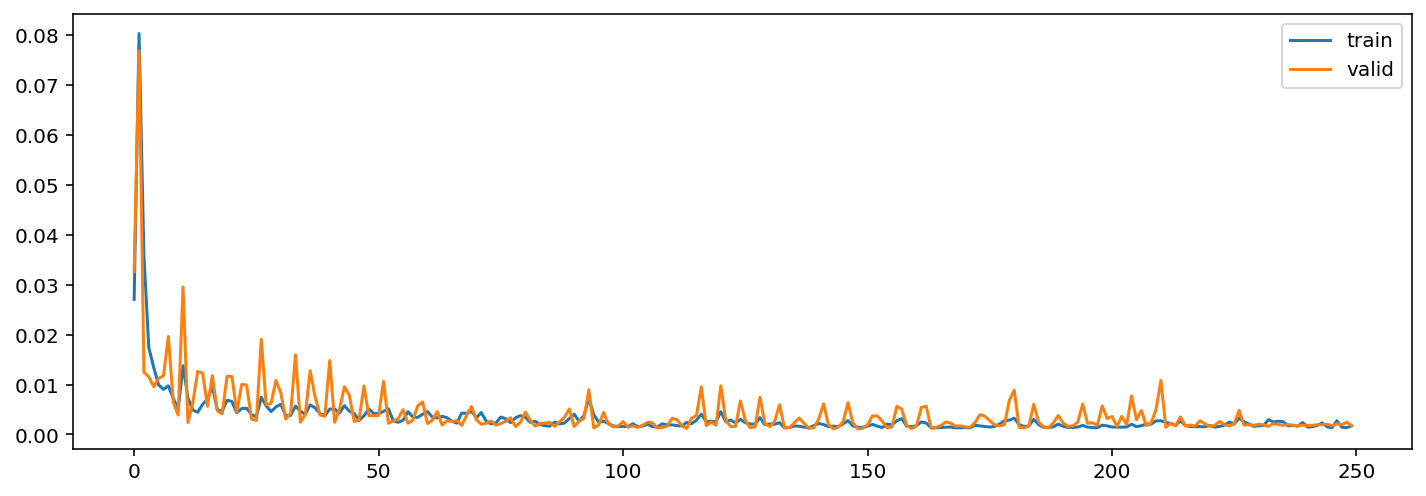

best epoch for valid set 143
best loss for valid set 0.0011218793925008405
------------------------------------------------------------------------------------------
calculations for 144 nodes - 0.2 dropout_rate - 1 layer tanh-fx started..
total time for learning: 62.161338567733765 sec


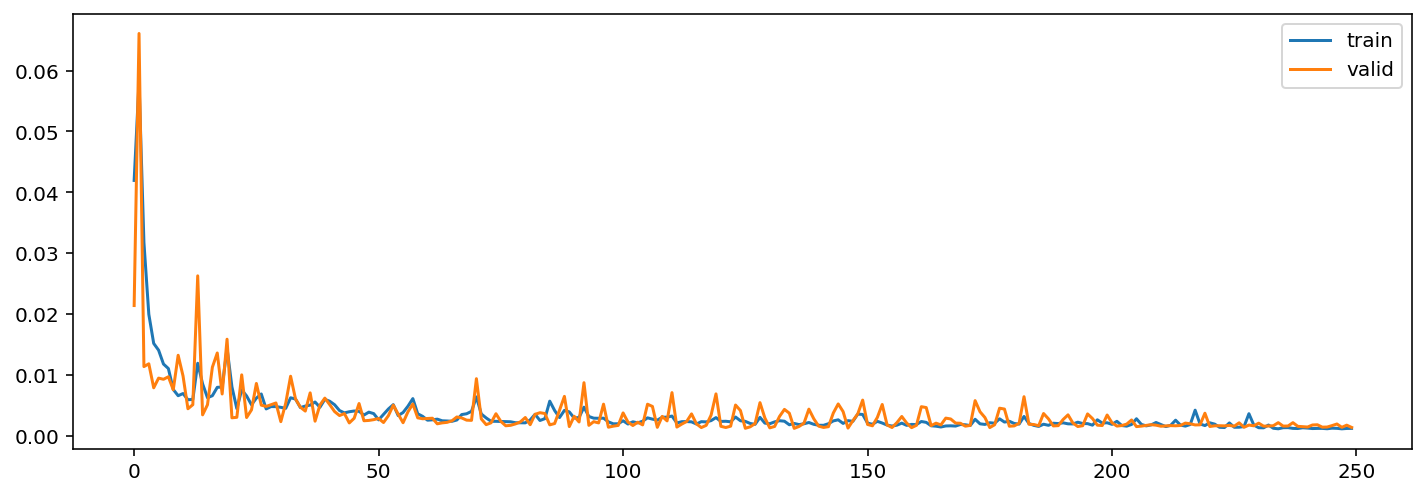

best epoch for valid set 135
best loss for valid set 0.001219863940219758
------------------------------------------------------------------------------------------


In [24]:
# 5.1. Search on optimal model params
# attention: this cell can take up to 20 minutes with activated CUDA and 1080Ti
# it is recommended to ignore this cell
# do not run this cell or do not restart kernel with CLEAR output in order to keep results of previous run

lstm_n = [90, 128, 144]
dropout_rates = [0.1, 0.15, 0.2]
n_lstm = [0]
lstm_activation = ['tanh']

combs = list(itertools.product(lstm_n, dropout_rates, n_lstm, lstm_activation))

titles = [str(i[0])+' nodes - '+str(i[1])+' dropout_rate - '+str(1+i[2])+' layer '+str(i[3])+'-fx' for i in combs]

param_grid = {t:dict(matrix_shape=train_tensor.shape[1:],
                    lstm_units=c[0],
                    dropout_rate=c[1],
                    n_internal_lstm=c[2], 
                    lstm_activation=c[3]) 
              for t,c in zip(titles, combs)}

valid_losses, valid_epochs = [], []

for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, train_tensor, train_target, n_epochs=250, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), 
                           use_early_stopping=False)

    v_loss = np.array(history.history['val_loss'])
    
    valid_losses.append(v_loss.min())
    valid_epochs.append(v_loss.argmin())
    
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

In general, there is no increase in metrics after FS adding to input data and metrics are quite close to each other.  

As the final architecture, the following version is chosen:
LSTM(128, activation='tanh') - Dropout(0.20) - FC(1)

In [25]:
# 5.2. Optimal params

opt_params_fs =  dict(
                          lstm_units=128, lstm_activation='tanh', use_dropout=True, dropout_rate=0.20, 
                          n_internal_lstm=0, add_internal_dense=False, optimizer='adam', 
                          loss_function='mse', show_model_layers=False
                          ) 

In [26]:
# 5.3. Fitting the model. Saving model
# attention: this cell can take up to 20 minutes with activated CUDA and GPU (1080Ti)
# it is recommended to ignore this cell
# do not run this cell or do not restart kernel with CLEAR output in order to keep results of previous run

target = chosen_ticker
print(f'{target} started ...')
    
model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **opt_params_fs)
history = fit_run_plot(model, train_tensor, train_target, n_epochs=250, batch_size=16, 
                       validation_split=0.15, verbose_mode=0, show_chart=False, display_total_time=False, 
                       display_model_summary=False, return_history=True, use_early_stopping=False)
    
epoch_step = np.array(history.history['val_loss']).argmin()
v_loss = np.array(history.history["val_loss"]).min()
    
print(f'optimum epochs number {epoch_step} with val loss = {v_loss}')
final_model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **opt_params_fs)
final_model = fit_run_plot(final_model, train_tensor, train_target, n_epochs=epoch_step, batch_size=16, 
                           validation_split=0.01, verbose_mode=0, show_chart=False, display_total_time=False, 
                           display_model_summary=False, return_history=False, use_early_stopping=False)
    
path = f'models/{chosen_ticker}_fs.h5'
#final_model.save(path)

In [27]:
# 5.4. CHECKPOINT: loading saved model
path = f'models/{chosen_ticker}_fs.h5'
fs_model = load_model(path)

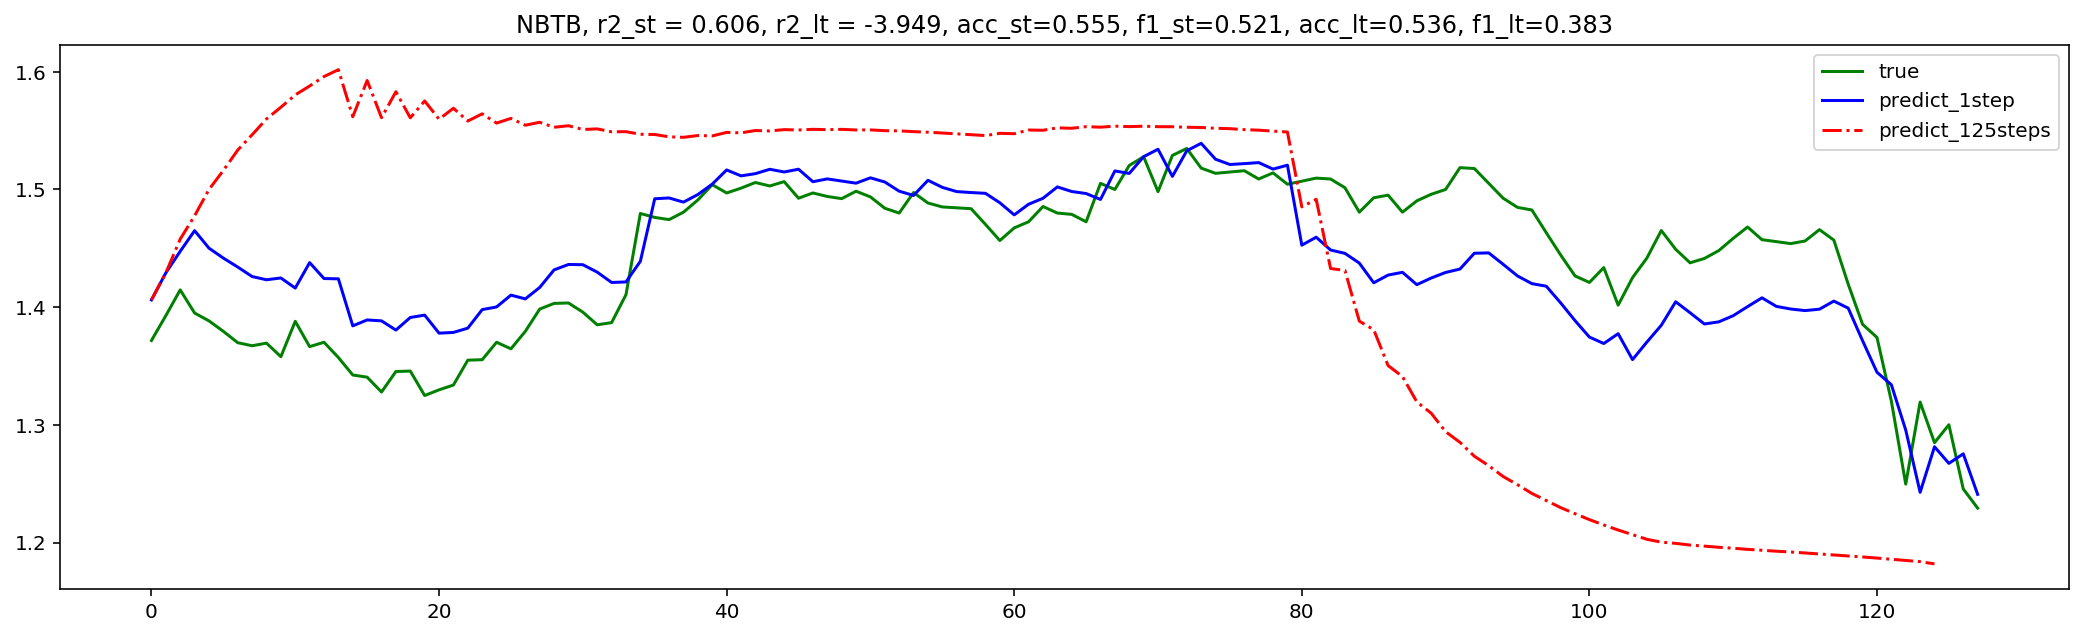

In [28]:
# 5.5. Forecast

target = chosen_ticker

pred, true = forecast_1step_rnn(fitted_model=fs_model, scaler_target=target_scaler, test_tensor=test_tensor,
                                       test_scaled=df_test_scaled, target_name=chosen_ticker, plot_chart=False)


pred_lt, true_lt = forecast_Nsteps_rnn(N_periods=125, fitted_model=fs_model, scaler_target=target_scaler, 
                                        test_scaled=df_test_scaled, target_name=chosen_ticker, plot_chart=False)

pred_bin = create_binnary_vector(pred) 
true_bin = create_binnary_vector(true)
true_lt_bin = create_binnary_vector(true_lt)
pred_lt_bin = create_binnary_vector(pred_lt) 

r2 = round(r2_score(true, pred),3)
r2_lt = round(r2_score(true_lt, pred_lt),3)
acc = round(accuracy_score(true_bin, pred_bin),3)
acc_lt = round(accuracy_score(true_lt_bin, pred_lt_bin),3)
f1 = round(f1_score(true_bin, pred_bin),3)
f1_lt = round(f1_score(true_lt_bin, pred_lt_bin),3)

fig, ax = plt.subplots(1,1, figsize=(18,5))
ax.plot(true, c='g', label='true')
ax.plot(pred, c='b', label='predict_1step')
ax.plot(pred_lt, c='r', label='predict_125steps', linestyle='-.')
ax.legend(loc='best')

ax.set_title(f'{chosen_ticker}, r2_st = {r2}, r2_lt = {r2_lt}, acc_st={acc}, f1_st={f1}, acc_lt={acc_lt}, f1_lt={f1_lt}')
plt.show()

- As the calculation showed, adding data on quarterly financial statements only worsened the quality of the model, the metric R2_score fell to 0.61. 
- Perhaps this is due to the fact that the actual data on prices is small and they add more noise to the model. 
- Or for the real estimation of impact, it is necessary to increase timeline significantly. 
- An important factor is that if in the used data the financial statements are entered on the corresponding dates of the beginning of the quarters, then in real life there is a significant time lag between the date of the beginning of the quarter and the date of the actual publication of fs, which is not accounted for in the used data.

Thus, based on the research of this notebook and the data used here, we can say that the impact of quarterly financial statements can not be used effectively in training the model on daily quotes.